<a href="https://colab.research.google.com/github/TimOgden/RoastBot/blob/master/RoastTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import time
import collections
import pandas
from tqdm.notebook import tqdm
import json
import random
import matplotlib.pyplot as plt
#from PIL import Image

In [2]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(1000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [3]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [85]:
BATCH_SIZE = 16

In [5]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model=256, dff=2048, dropout=.1, name=None):
        super().__init__(name=name)
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()

    def call(self, x, training, mask):
        attention_weights, _ = self.self_attention(x, x, attention_mask=mask,
                                                    return_attention_scores=True)
        normalized = self.layer_norm1(x + attention_weights)
        x = self.fc2(self.dropout(self.fc1(normalized), training=training))
        return self.layer_norm2(x + normalized)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)

        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask,
                                              return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        #print('Encoder output shape:', enc_output.shape)
        #print('Decoder layer output shape:', out1.shape)
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask,
                                    return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.fc2(self.dropout3(self.fc1(out2), training=training))
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [6]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        #print('Patches shape:',patch.shape)
        
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.tile(tf.expand_dims(positions,0),[BATCH_SIZE,1])
        #print('Positions shape:',positions.shape)
        projection = self.projection(patch)
        embeddings = self.position_embedding(positions)
        #print('Projection shape:', projection.shape)
        #print('Embeddings shape:', embeddings.shape)
        encoded = projection + embeddings
        return encoded

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_size,
               maximum_positional_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.input_size = input_size
        self.num_layers = num_layers
        self.patches = Patches(16)
        self.patch_encoder = PatchEncoder(576, d_model)
        self.pos_encoding = positional_encoding(maximum_positional_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(num_heads, d_model, dff, dropout=rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(74)
    def call(self, x, training, mask):
        patches = self.patches(x)
        x = self.patch_encoder(patches)
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        x = self.dense(self.flatten(x))
        return tf.reshape(x, [-1, 74, 1])

In [10]:
sample_encoder = Encoder(num_layers=1, d_model=256, num_heads=8,
                         dff=1024, input_size=16*16*3,
                         maximum_positional_encoding=10000)
temp_input = tf.random.uniform((BATCH_SIZE,384,384,3), dtype=tf.float32, minval=0, maxval=1.)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
print(sample_encoder_output.shape)

(8, 74, 1)


In [11]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        #print('Seq length:', seq_len)
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        #print('Before decoder layers shape:', x.shape)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [13]:
sample_decoder = Decoder(num_layers=1, d_model=256, num_heads=8,
                         dff=1024, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer1_block2'].shape

(TensorShape([8, 74, 256]), TensorShape([8, 8, 74, 74]))

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self, num_encoders, num_decoders, d_model, num_heads, dff,
               input_size, target_vocab_size, img_input, target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_encoders, d_model, num_heads, dff,
                                input_size, img_input, rate)
        self.decoder = Decoder(num_decoders, d_model, num_heads, dff,
                               target_vocab_size, target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):
        enc_output = self.tokenizer(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [69]:
sample_transformer = Transformer(
    num_encoders=1, num_decoders=1, d_model = 256, num_heads = 8, dff = 2048,
    input_size = 9*16*16*3, target_vocab_size = 8000,
    img_input=10000, target=6000)

temp_input = tf.random.uniform((BATCH_SIZE,16,16,3), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               dec_padding_mask=None,
                               look_ahead_mask=None)

fn_out.shape

TensorShape([8, 74, 8000])

In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [17]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask # (seq_len, seq_len)

In [43]:
def create_masks(inp, tar):
    # Encoder padding mask
    #enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(tar)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [106]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), tf.int32))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [83]:
transformer = Transformer(
    num_encoders=1, num_decoders=1, d_model=256, num_heads=8, dff=1024,
    target_vocab_size=8000, img_input=10000, target=5000, input_size=16*16*3
)
transformer.layers

In [21]:
optimizer = tf.keras.optimizers.Adam()

In [22]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [86]:
annotation_file = './annotations/captions_train2014.json'
PATH = './train2014/'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [87]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [108]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:5000]
print(len(train_image_paths))

5000


In [109]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [110]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(tf.image.resize(img, (384, 384)), tf.float32) / 255.
    return img, image_path

In [111]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [112]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [113]:
# Choose the top k words from the vocabulary
top_k = 8000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [114]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=75)

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [115]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [116]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(20011, 20011, 5002, 5002)

In [117]:
# Feel free to change these parameters according to your system's configuration
BUFFER_SIZE = 1000
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE




In [118]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [119]:
dataset = dataset.map(lambda x, y: (load_image(x)[0], y))
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [120]:
dataset

<PrefetchDataset shapes: ((None, 384, 384, 3), (None, 75)), types: (tf.float32, tf.int32)>

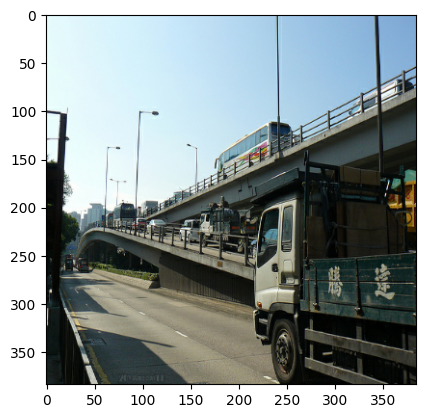

Sequence: tf.Tensor(
[  3   7 142 985   5   7  69  88  41   2 794   5 295   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(75,), dtype=int32)
Caption: ['<start>', 'the', 'truck', 'drives', 'on', 'the', 'side', 'road', 'near', 'a', 'highway', 'on', 'ramp', '<end>']


In [121]:
for (imgs, captions) in dataset.take(1):
    plt.imshow(imgs[0])
    plt.show()
    print('Sequence:', captions[0])
    print('Caption:', [tokenizer.index_word[i] for i in captions[0].numpy() if i != 0])

In [125]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [126]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

test_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    
    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 None,
                                 combined_mask,
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

@tf.function(input_signature=test_step_signature)
def test_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    
    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                    True,
                                    None,
                                    combined_mask,
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    test_loss(loss)
    test_accuracy(accuracy_function(tar_real, predictions))

In [124]:
for epoch in range(10):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in tqdm(enumerate(dataset)):
        train_step(inp, tar)

        if batch % 50 == 0:
              print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

            print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

0it [00:00, ?it/s]

Epoch 1 Batch 0 Loss 7.1388 Accuracy 0.1692
Epoch 1 Batch 5 Loss 6.6742 Accuracy 0.1432
Epoch 1 Batch 10 Loss 6.2983 Accuracy 0.1476
Epoch 1 Batch 15 Loss 6.0773 Accuracy 0.1689
Epoch 1 Batch 20 Loss 5.9612 Accuracy 0.1853
Epoch 1 Batch 25 Loss 5.7916 Accuracy 0.1989
Epoch 1 Batch 30 Loss 5.6600 Accuracy 0.2085
Epoch 1 Batch 35 Loss 5.5335 Accuracy 0.2197
Epoch 1 Batch 40 Loss 5.4512 Accuracy 0.2293
Epoch 1 Batch 45 Loss 5.3794 Accuracy 0.2405
Epoch 1 Batch 50 Loss 5.2736 Accuracy 0.2558
Epoch 1 Batch 55 Loss 5.1645 Accuracy 0.2718
Epoch 1 Batch 60 Loss 5.0773 Accuracy 0.2841
Epoch 1 Batch 65 Loss 4.9896 Accuracy 0.2947
Epoch 1 Batch 70 Loss 4.9156 Accuracy 0.3035
Epoch 1 Batch 75 Loss 4.8431 Accuracy 0.3115
Epoch 1 Batch 80 Loss 4.7669 Accuracy 0.3200
Epoch 1 Batch 85 Loss 4.7034 Accuracy 0.3286
Epoch 1 Batch 90 Loss 4.6221 Accuracy 0.3386
Epoch 1 Batch 95 Loss 4.5488 Accuracy 0.3483
Epoch 1 Batch 100 Loss 4.4805 Accuracy 0.3573
Epoch 1 Batch 105 Loss 4.4023 Accuracy 0.3682
Epoch 1 Ba

KeyboardInterrupt: 

In [ ]:
transformer.summary()